**Emotional Detection**

**importing libraries**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt # to visualaze the model performance
import numpy as np
from glob import glob # to make everything as a list present in the directory
import cv2 # to read and perform actions on images
import random
import os

%matplotlib inline 

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.2


**Exploring Dataset**

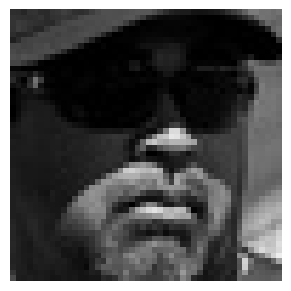

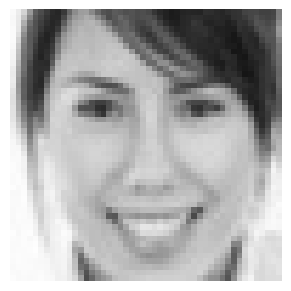

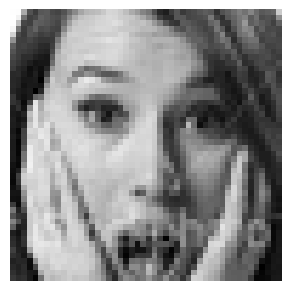

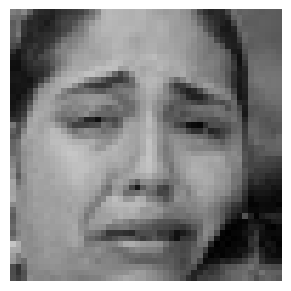

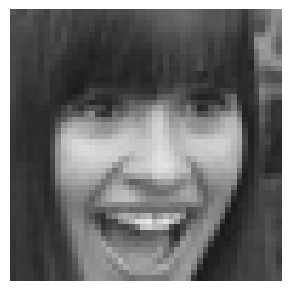

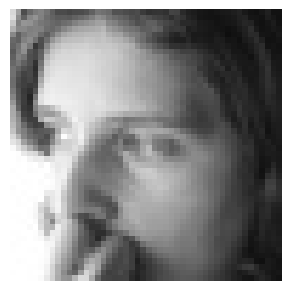

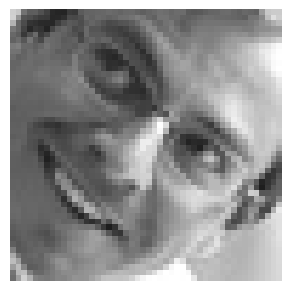

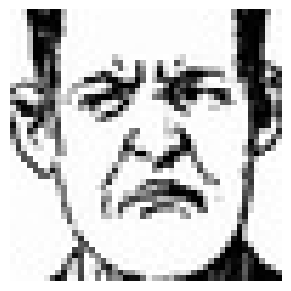

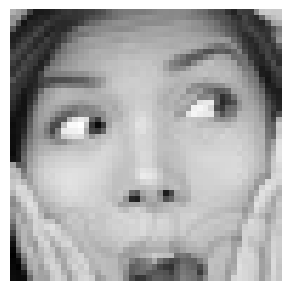

In [6]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

**Preparing data for training**

In [8]:
img_size = 48
batch_size = 64 # Hyperparameter any value can be given

datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/", 
                                                    target_size = (img_size,img_size), 
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

datagen_test = ImageDataGenerator()
test_generator = datagen_train.flow_from_directory("test/", 
                                                    target_size = (img_size,img_size), 
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**

In [12]:
def convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters,
               kernel_size = kernel_size,
               padding ="same",)(input_tensor)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size= (2,2))(x)
    x = Dropout(0.25)(x)

    return x

In [15]:
def dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [17]:
def model_f(input_shape):
    inputs = Input(input_shape)
    conv_1 = convolution(inputs, 64, (3,3))
    conv_2 = convolution(conv_1, 128, (5,5))
    conv_3 = convolution(conv_2, 512, (3,3))
    conv_4 = convolution(conv_3, 512, (3,3))

    flatten = Flatten()(conv_4)

    dense_1 = dense_f(flatten,256)
    dense_2 = dense_f(dense_1,512)
    
    output = Dense(7, activation="softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    
    opt = Adam(learning_rate = 0.0005)
    model.compile(loss = ['categorical_crossentropy'], optimizer = opt, metrics = ['accuracy'])

    return model

In [19]:
model = model_f((48,48,1))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,90

 Total params: 4,343,303 (16.57 MB)

 Trainable params: 4,340,359 (16.56 MB)

 Non-trainable params: 2,944 (11.50 KB)

**Initilizing the Model**

In [22]:
epochs = 20
steps_per_epoch = train_generator.n// train_generator.batch_size
test_steps = test_generator.n // test_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,patience = 2, min_lr = 0.0001)
callbacks = [checkpoint, reduce_lr]

**Training the Model**

In [25]:
history = model.fit(x=train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=test_steps,
                    callbacks=callbacks)

Epoch 1/20


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.2861 - loss: 1.9012
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 393s 857ms/step - accuracy: 0.2862 - loss: 1.9007 - val_accuracy: 0.4047 - val_loss: 1.5929 - learning_rate: 5.0000e-04
Epoch 2/20
  1/448 ━━━━━━━━━━━━━━━━━━━━ 6:17 844ms/step - accuracy: 0.2500 - loss: 1.6622
Epoch 2: saving model to model_weights.weights.h5


C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.2500 - loss: 1.6622 - val_accuracy: 0.2000 - val_loss: 1.7987 - learning_rate: 5.0000e-04
Epoch 3/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.4590 - loss: 1.4281
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 365s 814ms/step - accuracy: 0.4590 - loss: 1.4280 - val_accuracy: 0.4640 - val_loss: 1.4531 - learning_rate: 5.0000e-04
Epoch 4/20
  1/448 ━━━━━━━━━━━━━━━━━━━━ 6:15 840ms/step - accuracy: 0.4219 - loss: 1.2927
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - accuracy: 0.4219 - loss: 1.2927 - val_accuracy: 0.2000 - val_loss: 1.8015 - learning_rate: 5.0000e-04
Epoch 5/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.5249 - loss: 1.2578
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 367s 819ms/step - accuracy: 0.5249 - loss: 1.2578 - val_accuracy: 0.5099 - val_loss: 1.3101 - learning_rate: 5.0

**Model Evaluation**

In [27]:
model.evaluate(test_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - accuracy: 0.6376 - loss: 1.0076


[1.0065102577209473, 0.6334633827209473]

**Plotting Loss**

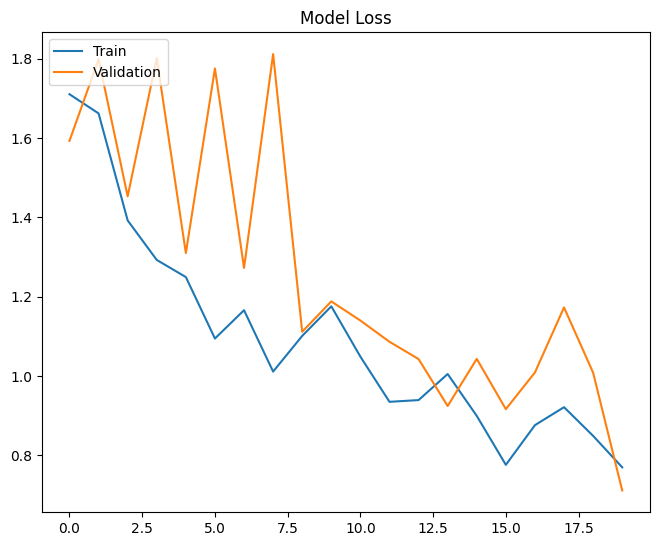

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom= 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace=0.35)

**Plotting Model Accuracy**

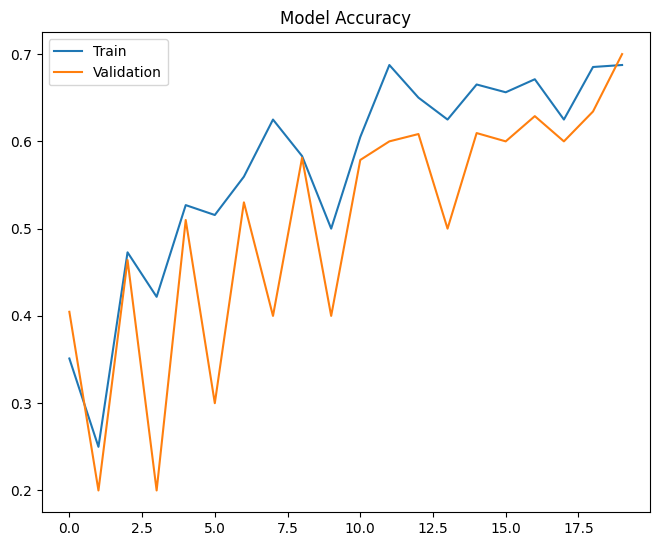

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom= 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace=0.35)

**Saving Model**

In [33]:
model_json = model.to_json()
with open('model_a.json', 'w') as json_file:
    json_file.write(model_json)